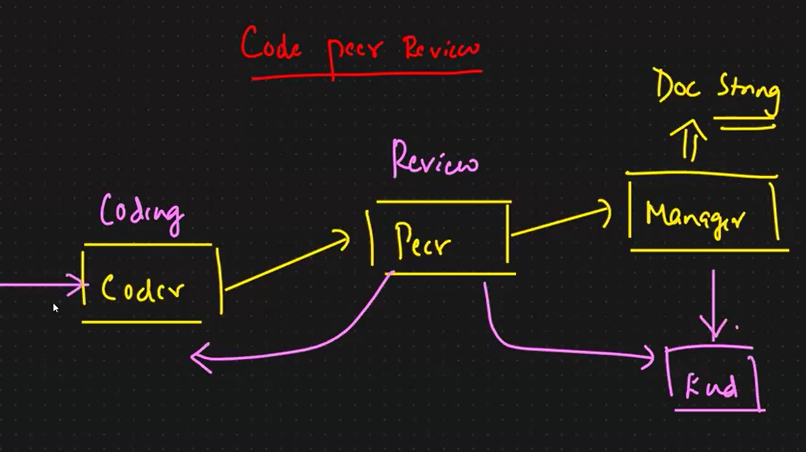

code --> review --> generate the test cases --> Analyze the failed test cases --> Give Summary

In [1]:
# Importing the required libraries
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
from typing_extensions import Annotated, List, TypedDict, Literal
from langchain.document_loaders import PythonLoader
import operator
from langgraph.constants import Send
load_dotenv()

True

In [2]:
# Loading the environment variables
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")

In [3]:
llm = ChatGroq(model="llama-3.1-8b-instant",temperature=0.3)
llm.invoke("Hi! I am Hrishikesh")

AIMessage(content='Nice to meet you, Hrishikesh. Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 43, 'total_tokens': 69, 'completion_time': 0.034666667, 'prompt_time': 0.002282893, 'queue_time': 0.051268756, 'total_time': 0.03694956}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a56f6eea01', 'finish_reason': 'stop', 'logprobs': None}, id='run-43b554c9-87a9-4b37-b081-1726a407ee6a-0', usage_metadata={'input_tokens': 43, 'output_tokens': 26, 'total_tokens': 69})

In [4]:
# Prompts
reviewer_prompt = """You are a senior Python developer with 10+ year of experience in software development. 
Your task is to analyze the provided Python code and evaluate it based on the following criteria:

Syntax Errors: Identify and highlight any syntax-related issues.
Indentation & Formatting: Check if the code follows proper indentation and is formatted according to Pythonic conventions (PEP 8).
Readability: Assess whether the code is easy to understand and suggest improvements for clarity.
Modularity & Structure: Determine if the code follows best practices in terms of function usage, reusability, and separation of concerns.
Docstrings & Comments: Verify if the code includes meaningful docstrings and comments to enhance maintainability.

Provide a detailed review highlighting any issues found and recommendations for improvement based on above criteria only.
If no changes required in code and code follows the all predefined criteria, answer in 'yes' or 'no'. If changes required say 'yes' and If no changes required say 'no'."""

llm_evaluator_prompt = """
You are an expert Python engineer. Your task is to evaluate the provided code based on the following criteria:

1. Performance: Is the code optimized for speed and memory usage? Identify any bottlenecks.
2. Time & Space Complexity: Analyze the complexity of key operations and suggest improvements.
3. Algorithm Quality: Is the algorithm appropriate and efficient? Suggest better alternatives if any.
4. Edge Cases & Error Handling: Does the code handle edge cases and errors robustly?
5. Scalability: Will this code perform well with large input sizes?
6. Correctness: Does the code produce accurate results? Are all key scenarios covered?

Provide a brief summary, highlight issues, and suggest improvements focused on performance, complexity, and robustness only.
"""

human_evaluator_prompt = """
You are a code evaluation assistant. Your task is to analyze the human feedback given for the generated/updated Python code and decide whether further code updates are needed.

Instructions:
- Carefully read and interpret the human feedback.
- Reason through the points raised.
- Based on the feedback, determine if the code still needs improvements or modifications.

Respond with a clear "yes" if code updates are required based on feedback, or "no" if the code is acceptable as-is.

Human Feedback: {human_feedback}
"""


testing_overview_prompt = """
You are an experienced Python developer and software tester. Your task is to generate a list of unit test case names and their descriptions for the provided Python code.

Instructions:
1. Provide meaningful test case names following `unittest` naming conventions.
2. For each test case, include a short description explaining what the test is verifying.
3. Cover all core functionalities and important edge cases.
4. Do not write actual test code — only test names and their purposes.

Output should be a clear list of test case names with corresponding descriptions.
"""

tester_prompt = """
You are an experienced Python developer and software tester. Your task is to generate complete Python unit tests using the `unittest` framework based on the provided test case names and their descriptions.

Instructions:
1. Use the test case name as the function name.
2. Implement the logic according to the description provided.
3. Follow Python's `unittest` best practices.
4. Cover input, expected output, and necessary assertions.
5. If the function prints output, capture and validate it.
6. Ensure the test code is clean, maintainable, and ready to run.

Input will be a list of test case names and descriptions. Output only the complete `unittest` code implementing these test cases.
Python code for which you have to generate tests : {python_code}
"""


In [5]:
class CodeReviewerModel(BaseModel):
    reviews: List[str] = Field(description="review points given by llm to the generated code about potential improvements")
    grade: Literal["yes","no"] = Field(
        description="Based on reviews given by reviewer decide, code changes required 'yes' or 'no'."
    )
    
class HumanFeedbackModel(BaseModel):
    grade: Literal["yes","no"] = Field(
        description="Decide based on the human feedback, code update required or not ?. Answer in 'yes' or 'no'"
    )
    
class LLMFeedbackModel(BaseModel):
    grade: Literal["yes","no"] = Field(
        description="Decide based on the llm feedback, code update required or not ? Answer in 'yes' or 'no'"
    )
    feedback: str = Field(
        description="feedback provided by llm to make improvement in the code",
    )

class CodeUpdaterModel(BaseModel):
    updated_code: str = Field(
        description="The updated code which is generated after improvements."
    )
    
class TestsOverview(BaseModel):
    name: str = Field(
        description="Name of the test case.",
    )
    description: str = Field(
        description="Brief overview of the tests, what the particular test is all about. what it is going to test.",
    )
    
class TestsOverviewGenerator(BaseModel):
    tests_overview : List[TestsOverview] = Field(description="List of tests name and description")
    
class TestGeneratorModel(BaseModel):
    unit_test: str = Field(description="Unit test code in python using unittest library")

In [6]:
class MessageState(TypedDict):
    python_code: str
    reviews: List[str]
    review_grade:str
    human_feedback: str
    llm_feedback:str
    llm_grade:str
    human_grade:str
    testcases: List[TestsOverview]
    completed_tests: Annotated[list,operator.add]
    
class WorkerState(TypedDict):
    python_code: str
    testcase: TestsOverview
    completed_tests: Annotated[list,operator.add]

In [7]:
def read_file(file_path):
    python_loader = PythonLoader(file_path=file_path)
    code_docs = python_loader.load()
    
    python_code = ""
    for doc in code_docs:
        python_code = python_code.join(doc.page_content)
    return python_code    

In [8]:
def code_reviewer(state:MessageState):
    python_code = state["python_code"]
    Reviewer = llm.with_structured_output(CodeReviewerModel)
    system_message = SystemMessage(content=reviewer_prompt)
    reviewer = Reviewer.invoke([system_message]+[HumanMessage(content=f"Review the give python code : {python_code}")])
    grade = reviewer.grade
    reviews = reviewer.reviews
    return {"reviews":reviews,"review_grade":grade}

In [9]:
def code_updater(state:MessageState):
    if state.get("llm_feedback","") or state.get("human_feedback",""):
        python_code = state["python_code"]
        llm_feedback = state['llm_feedback']
        human_feedback = state['human_feedback']
        
        system_message = SystemMessage(content="Based on the provided feedback from LLM and Human. Update the code")
        CodeUpdater = llm.with_structured_output(CodeUpdaterModel)
        code_updater = CodeUpdater.invoke([system_message]+[HumanMessage(content=f"Update the code : {python_code}.\n Based on feedback provided by the llm and human. LLM Feedback : {llm_feedback} \n Human Feedback : {human_feedback}")])
        updated_code = code_updater.updated_code
    else:
        python_code = state["python_code"]
        reviews = state["reviews"]
        
        system_message = SystemMessage(content="Based on the reviews given by senior developer make changes in the code.")
        CodeUpdater = llm.with_structured_output(CodeUpdaterModel)
        code_updater = CodeUpdater.invoke([system_message]+[HumanMessage(content=f"Update the code : {python_code}.\n Based on the reviews : {reviews}")])
        updated_code = code_updater.updated_code
    return {"python_code":updated_code}

In [10]:
def llm_code_evaluator(state:MessageState):
    system_message = SystemMessage(content=llm_evaluator_prompt)
    LLMFeedbackEvaluator = llm.with_structured_output(LLMFeedbackModel)
    llm_feedback_evaluator = LLMFeedbackEvaluator.invoke([system_message]+[HumanMessage(content=f"Evaluate the generated code : {state['python_code']}")])
    grade = llm_feedback_evaluator.grade
    feedback = llm_feedback_evaluator.feedback
    return {"llm_feedback":feedback,"llm_grade":grade}

In [11]:
def human_code_evaluator(state:MessageState):
    print("---- HUMAN FEEDBACK EVALUATION ----")
    system_message = human_evaluator_prompt.format(human_feedback=state["human_feedback"])
    HumanFeedbackEvaluator = llm.with_structured_output(HumanFeedbackModel)
    human_feedback_evaluator=HumanFeedbackEvaluator.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Evaluate the human feedback given for the updated code")])
    grade = human_feedback_evaluator.grade
    # print("Human grade : ",grade)
    return {"human_feedback":state["human_feedback"],"human_grade":grade}

In [12]:
def route_to_update(state:MessageState):
    if state["llm_grade"]=="yes" and state["human_grade"] == "yes":
        return "Code Updation"
    elif state["llm_grade"] == "no" and state["human_grade"] == "no":
        return "No Updation"
    elif state["llm_grade"] == "no" and state["human_grade"] == "yes":
        return "Code Updation"
    elif state["llm_grade"] == "yes" and state["human_grade"] == "no":
        return "No Updation"
        

In [13]:
def route_to_review(state:MessageState):
    if state['review_grade'] == 'yes':
        return 'Code Updation'
    elif state['review_grade'] == 'no':
        return "No Updation"

In [14]:
def test_overview_generator(state:MessageState):
    TestOverviewGenerator = llm.with_structured_output(TestsOverviewGenerator)
    tests_overview = TestOverviewGenerator.invoke(
            [
                SystemMessage(content=testing_overview_prompt),
                HumanMessage(content=f"Generate the tests for the python code : {state['python_code']}."),
            ]
        )
    return {"testcases":tests_overview.tests_overview}

In [15]:
def store_test(unit_test,name):
    current_dir = os.getcwd()
    folder_name="tests"
    folder_path = os.path.join(current_dir,folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    file_path = os.path.join(folder_path,f"{name}.py")
    with open(file_path,'w') as f:
        f.write(unit_test)

In [16]:
def testcase_generater(state:WorkerState):
    """Generates the testcases for the given name and description"""
    
    system_message = SystemMessage(content=tester_prompt.format(python_code=state["python_code"]))
    human_message = HumanMessage(content=f"Take the test case name and description from the state and generate the corresponding unit test cases. \
                                 testcase name : {state['testcase'].name} \n testcase description : {state['testcase'].description}")
    test_generator = llm.with_structured_output(TestGeneratorModel)
    testcase = test_generator.invoke([system_message]+[human_message])
    testcase_name = state['testcase'].name
    store_test(testcase.unit_test,testcase_name)
    
    return {"completed_tests":[testcase.unit_test]}


In [17]:
def assign_workers(state: MessageState):
    """Assign a worker to each testcase in the testcases list"""

    # Kick off section writing in parallel via Send() API
    return [Send("testcase_generater", {"testcase": test,"python_code":state['python_code']}) for test in state["testcases"]]

In [18]:
graph = StateGraph(MessageState)

graph.add_node("reviewer",code_reviewer)
graph.add_node("code_updater",code_updater)
graph.add_node("code_evaluator",llm_code_evaluator)
graph.add_node("human_code_evaluator",human_code_evaluator)
graph.add_node("test_overview_generator",test_overview_generator)
graph.add_node("testcase_generater",testcase_generater)

graph.add_edge(START,"reviewer")
graph.add_edge("reviewer","code_updater")
graph.add_conditional_edges("code_updater",
                            route_to_review,
                            {"Code Updation":"reviewer",
                             "No Updation":"code_evaluator"})

graph.add_edge("code_evaluator","human_code_evaluator")
graph.add_conditional_edges("human_code_evaluator",
                            route_to_update,
                            {"Code Updation":"code_updater",
                             "No Updation":"test_overview_generator"})
# graph.add_edge("test_overview_generator","testcase_generater")
graph.add_conditional_edges("test_overview_generator",assign_workers,["testcase_generater"])
workflow = graph.compile(interrupt_before=["human_code_evaluator"],checkpointer=MemorySaver())

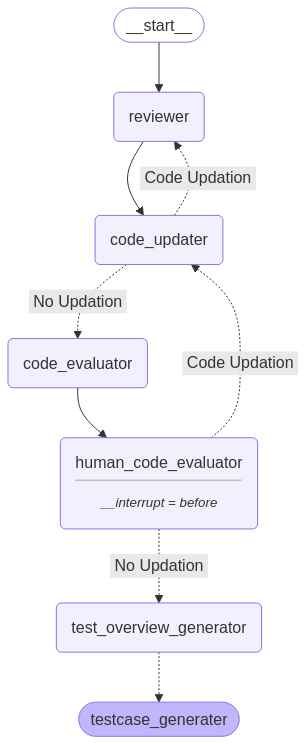

In [19]:
workflow

In [20]:
# Define the config
from datetime import datetime
config  = {"configurable":{"thread_id": datetime.now().strftime("%Y%m%d%H%M%S%f")}}

In [21]:
python_code = read_file("tower_of_hanoi.py")

In [22]:
print(python_code)

def tower_of_hanoi(n, source, target, auxiliary):
    if n == 1:
        print(f'Move disk 1 from {source} to {target}')
        return
    tower_of_hanoi(n - 1, source, auxiliary, target)
    print(f'Move disk {n} from {source} to {target}')
    tower_of_hanoi(n - 1, auxiliary, target, source)

tower_of_hanoi(3, 'A', 'C', 'B')


In [23]:
# initial_state = {
#             "python_code": python_code,
#             "reviews": [],
#             "review_grade": "",
#             "human_feedback": "",
#             "llm_feedback": "",
#             "llm_grade": "",
#             "human_grade": "",
#             "testcases": [],
#             "completed_tests": [],
#         }


In [24]:
# state = workflow.stream(input=initial_state,config=config,stream_mode="values")

In [ ]:
# state

<generator object Pregel.stream at 0x00000293DA4890E0>

In [31]:
workflow.invoke(input={'python_code':python_code},config=config,stream_mode="values")

{'python_code': 'def tower_of_hanoi(n, source, target, auxiliary):\n    if n == 0:\n        print("Invalid number of disks. Please provide a positive integer.")\n        return\n    if not source or not target or not auxiliary:\n        print("Invalid disk names. Please provide unique and non-empty names.")\n        return\n    if source == target or source == auxiliary or target == auxiliary:\n        print("Invalid disk names. Please provide unique names.")\n        return\n    if n == 1:\n        print(f\'Move disk 1 from {source} to {target}\')\n        return\n    tower_of_hanoi(n - 1, source, auxiliary, target)\n    print(f\'Move disk {n} from {source} to {target}\')\n    tower_of_hanoi(n - 1, auxiliary, target, source)\n\ntower_of_hanoi(3, \'A\', \'C\', \'B\')',
 'reviews': ['The code follows proper indentation and is formatted according to Pythonic conventions (PEP 8).',
  'The code is well-structured and follows a clear recursive approach to solve the Tower of Hanoi problem.',

In [25]:
for event in workflow.stream(input={'python_code':python_code},config=config,stream_mode="updates"):
    print(event)
    print('\n')

{'reviewer': {'reviews': ['The code follows proper indentation and is formatted according to Pythonic conventions (PEP 8).', 'The code is well-structured and follows the best practices in terms of function usage, reusability, and separation of concerns.', 'The code includes meaningful comments to enhance maintainability.', 'The code is easy to understand and does not have any syntax-related issues.', 'The code follows the modularity and structure criteria.', 'The code includes meaningful docstrings to enhance maintainability.'], 'review_grade': 'no'}}


{'code_updater': {'python_code': 'def tower_of_hanoi(n, source, target, auxiliary):\n    """This function solves the Tower of Hanoi problem.\n\n    Args:\n        n (int): The number of disks.\n        source (str): The source peg.\n        target (str): The target peg.\n        auxiliary (str): The auxiliary peg.\n\n    Returns:\n        None\n    """\n    if n == 1:\n        print(f\'Move disk 1 from {source} to {target}\')\n        r

In [26]:
workflow.get_state(config).values

{'python_code': 'def tower_of_hanoi(n, source, target, auxiliary):\n    """This function solves the Tower of Hanoi problem.\n\n    Args:\n        n (int): The number of disks.\n        source (str): The source peg.\n        target (str): The target peg.\n        auxiliary (str): The auxiliary peg.\n\n    Returns:\n        None\n    """\n    if n == 1:\n        print(f\'Move disk 1 from {source} to {target}\')\n        return\n    tower_of_hanoi(n - 1, source, auxiliary, target)\n    print(f\'Move disk {n} from {source} to {target}\')\n    tower_of_hanoi(n - 1, auxiliary, target, source)\n\n# Call the function\ntower_of_hanoi(3, \'A\', \'C\', \'B\')',
 'reviews': ['The code follows proper indentation and is formatted according to Pythonic conventions (PEP 8).',
  'The code is well-structured and follows the best practices in terms of function usage, reusability, and separation of concerns.',
  'The code includes meaningful comments to enhance maintainability.',
  'The code is easy to un

In [27]:
user_feeedback = input("Do you want to provide any instructions ? : ")
state = workflow.update_state(config=config,values={"human_feedback":user_feeedback})

In [28]:
state

{'configurable': {'thread_id': '20250319234029579283',
  'checkpoint_ns': '',
  'checkpoint_id': '1f004eec-79df-6386-8004-05badd8fdc05'}}

In [29]:

print(workflow.get_state(config).values)
print(workflow.get_state(config).next)

{'python_code': 'def tower_of_hanoi(n, source, target, auxiliary):\n    """This function solves the Tower of Hanoi problem.\n\n    Args:\n        n (int): The number of disks.\n        source (str): The source peg.\n        target (str): The target peg.\n        auxiliary (str): The auxiliary peg.\n\n    Returns:\n        None\n    """\n    if n == 1:\n        print(f\'Move disk 1 from {source} to {target}\')\n        return\n    tower_of_hanoi(n - 1, source, auxiliary, target)\n    print(f\'Move disk {n} from {source} to {target}\')\n    tower_of_hanoi(n - 1, auxiliary, target, source)\n\n# Call the function\ntower_of_hanoi(3, \'A\', \'C\', \'B\')', 'reviews': ['The code follows proper indentation and is formatted according to Pythonic conventions (PEP 8).', 'The code is well-structured and follows the best practices in terms of function usage, reusability, and separation of concerns.', 'The code includes meaningful comments to enhance maintainability.', 'The code is easy to understan

In [57]:
# workflow.update_state(config=config,values={"human_feedback":"No changes required in the code now."})

In [58]:
workflow.get_state(config).values

{'python_code': 'def tower_of_hanoi(n, source_peg, target_peg, auxiliary_peg):\n    """Tower of Hanoi problem solution.\n\n    Args:\n        n (int): The number of disks.\n        source_peg (str): The source peg.\n        target_peg (str): The target peg.\n        auxiliary_peg (str): The auxiliary peg.\n\n    Raises:\n        ValueError: If n is not a positive integer or if the pegs are not distinct.\n    """\n    if not isinstance(n, int) or n < 1:\n        raise ValueError(\'n must be a positive integer\')\n    if source_peg == target_peg or source_peg == auxiliary_peg or target_peg == auxiliary_peg:\n        raise ValueError(\'source, target, and auxiliary pegs must be distinct\')\n\n    def recursive_tower_of_hanoi(n, source, target, auxiliary):\n        """Recursive function to solve the Tower of Hanoi problem.\n\n        Args:\n            n (int): The number of disks.\n            source (str): The source peg.\n            target (str): The target peg.\n            auxiliary 

In [59]:
workflow.get_state(config).next

('human_code_evaluator',)

In [60]:
for event in workflow.stream(None, config, stream_mode="updates"):
    # Review
    print(event)
    print("\n")

---- HUMAN FEEDBACK EVALUATION ----
{'human_code_evaluator': {'human_feedback': 'make it more optimized if possible', 'human_grade': 'yes'}}


{'code_updater': {'python_code': "def tower_of_hanoi(n, source_peg, target_peg, auxiliary_peg):\n    if not isinstance(n, int) or n < 1:\n        raise ValueError('n must be a positive integer')\n    if source_peg == target_peg or source_peg == auxiliary_peg or target_peg == auxiliary_peg:\n        raise ValueError('source, target, and auxiliary pegs must be distinct')\n\n    def recursive_tower_of_hanoi(n, source, target, auxiliary):\n        if n == 1:\n            print(f'Move disk 1 from {source} to {target}')\n            return\n        recursive_tower_of_hanoi(n - 1, source, auxiliary, target)\n        print(f'Move disk {n} from {source} to {target}')\n        recursive_tower_of_hanoi(n - 1, auxiliary, target, source)\n\n    recursive_tower_of_hanoi(n, source_peg, target_peg, auxiliary_peg)"}}


{'code_evaluator': {'llm_feedback': 'The co

In [61]:
print(workflow.get_state(config).values['python_code'])

def tower_of_hanoi(n, source_peg, target_peg, auxiliary_peg):
    if not isinstance(n, int) or n < 1:
        raise ValueError('n must be a positive integer')
    if source_peg == target_peg or source_peg == auxiliary_peg or target_peg == auxiliary_peg:
        raise ValueError('source, target, and auxiliary pegs must be distinct')

    def recursive_tower_of_hanoi(n, source, target, auxiliary):
        if n == 1:
            print(f'Move disk 1 from {source} to {target}')
            return
        recursive_tower_of_hanoi(n - 1, source, auxiliary, target)
        print(f'Move disk {n} from {source} to {target}')
        recursive_tower_of_hanoi(n - 1, auxiliary, target, source)

    recursive_tower_of_hanoi(n, source_peg, target_peg, auxiliary_peg)


In [64]:
user_feeedback = input("Do you want to provide any instructions ? : ")
workflow.update_state(config=config,values={"human_feedback":user_feeedback})

print(workflow.get_state(config).values)
print(workflow.get_state(config).next)

{'python_code': 'def tower_of_hanoi(n, source_peg, target_peg, auxiliary_peg):\n    """\n    Solves the Tower of Hanoi problem using recursion.\n\n    Args:\n        n (int): The number of disks.\n        source_peg (str): The source peg.\n        target_peg (str): The target peg.\n        auxiliary_peg (str): The auxiliary peg.\n\n    Raises:\n        ValueError: If n is not a positive integer or if the pegs are not distinct.\n    """\n    if not isinstance(n, int) or n < 1:\n        raise ValueError(\'n must be a positive integer\')\n    if source_peg == target_peg or source_peg == auxiliary_peg or target_peg == auxiliary_peg:\n        raise ValueError(\'source, target, and auxiliary pegs must be distinct\')\n\n    def recursive_tower_of_hanoi(n, source, target, auxiliary):\n        """\n        Recursive function to solve the Tower of Hanoi problem.\n\n        Args:\n            n (int): The number of disks.\n            source (str): The source peg.\n            target (str): The t

In [65]:
for event in workflow.stream(None, config, stream_mode="updates"):
    # Review
    print(event)
    print("\n")

---- HUMAN FEEDBACK EVALUATION ----
{'human_code_evaluator': {'human_feedback': 'no changes required now', 'human_grade': 'no'}}


{'test_overview_generator': {'testcases': [TestsOverview(name='test_tower_of_hanoi_valid_input', description='Test the function with valid input (positive integer, distinct pegs) and verify the output.'), TestsOverview(name='test_tower_of_hanoi_invalid_n', description='Test the function with invalid input (n is not a positive integer) and verify the ValueError is raised.'), TestsOverview(name='test_tower_of_hanoi_invalid_pegs', description='Test the function with invalid input (source, target, and auxiliary pegs are not distinct) and verify the ValueError is raised.'), TestsOverview(name='test_tower_of_hanoi_base_case', description='Test the function with the base case (n = 1) and verify the output.'), TestsOverview(name='test_tower_of_hanoi_recursive_case', description='Test the function with the recursive case (n > 1) and verify the output.')]}}


{'testc

In [66]:
workflow.get_state(config).next

()

In [67]:
unittests = workflow.get_state(config).values['completed_tests']
print(unittests[0])

import unittest

class TestTowerOfHanoi(unittest.TestCase):
    def test_tower_of_hanoi_valid_input(self):
        # Arrange
        n = 3
        source_peg = 'A'
        target_peg = 'C'
        auxiliary_peg = 'B'

        # Act
        with unittest.mock.patch('builtins.print', new_callable=unittest.mock.Mock) as mock_print:
            tower_of_hanoi(n, source_peg, target_peg, auxiliary_peg)

        # Assert
        expected_output = ['Move disk 1 from A to C', 'Move disk 2 from A to B', 'Move disk 1 from C to B', 'Move disk 3 from A to C', 'Move disk 1 from B to A', 'Move disk 2 from B to C', 'Move disk 1 from A to C']
        mock_print.assert_called_with(*expected_output)

if __name__ == '__main__':
    unittest.main()
